<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test. Como primera aproximación se ha decidido trabajar con un total de 50 ventanas por sujeto y no con todas, por cuestiones de tiempo de ejecución.

    1. Creación de los conjuntos Train y Test
    2. Preparación datos de entrada y salida

In [1]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [2]:
df= pd.read_csv('features.csv')

In [3]:
df.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
1318,68.0,71.0,69.43,1.00,-0.35,-0.35,-0.35,0.17,0.19,0.18,-0.93,-0.92,-0.92,2.0,1.0,1.0
3144,53.0,54.0,53.50,1.00,0.08,0.10,0.09,0.20,0.23,0.22,-0.98,-0.97,-0.97,5.0,0.0,3.0
16779,73.0,74.0,73.17,1.00,-0.50,-0.49,-0.49,0.84,0.85,0.85,-0.21,-0.20,-0.20,5.0,0.0,21.0
3660,69.0,70.0,69.83,1.00,-0.33,-0.30,-0.30,0.88,0.95,0.93,-0.24,-0.15,-0.19,2.0,1.0,4.0
890,59.0,60.0,59.17,1.00,0.07,0.08,0.08,-0.44,-0.43,-0.43,-0.90,-0.89,-0.90,2.0,1.0,1.0
13226,53.0,54.0,53.33,0.99,-0.17,-0.15,-0.16,-0.03,-0.02,-0.02,-0.99,-0.98,-0.98,2.0,1.0,16.0
15123,64.0,65.0,64.33,0.99,0.09,0.09,0.09,0.40,0.41,0.40,-0.91,-0.90,-0.90,2.0,1.0,18.0
25401,48.0,83.0,63.00,1.00,-0.70,0.35,-0.31,-1.11,0.59,0.28,-1.28,-0.71,-0.86,1.0,1.0,30.0
23739,73.0,77.0,75.60,1.00,-0.48,-0.47,-0.48,-0.25,-0.23,-0.24,-0.85,-0.84,-0.85,2.0,1.0,28.0
17661,64.0,65.0,64.80,1.00,0.67,0.68,0.68,0.45,0.46,0.46,-0.59,-0.58,-0.58,2.0,1.0,22.0


## 1. Creación de los conjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [4]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 21 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [0, 23, 8, 30, 10, 2, 5, 15, 14, 28, 11, 20, 19, 9, 7, 12, 21, 4, 6, 18, 24, 17, 1, 16]
7 sujetos de test: [3, 13, 22, 25, 26, 27, 29]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos:

In [5]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    train_matr.append(m)

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    test_matr.append(m)

En este caso, los conjuntos de Train y Test se han creado con **50 ventanas** deslizantes y no con todas.

In [6]:
lista_ventanas=list(np.linspace(0,0.9,30)) #[0,1/10,1/5,3/10,4/10,5/10,6/10,7/10,8/10,9/10]

Train = pd.DataFrame()  
for i in range(len(train_matr)):
    lista_multi=[int(element * len(train_matr[i])) for element in lista_ventanas]
    ven1=train_matr[i].iloc[lista_multi]
    Train=Train.append(ven1)

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    lista_multi=[int(element * len(test_matr[i])) for element in lista_ventanas]
    ven2=test_matr[i].iloc[lista_multi]
    Test=Test.append(ven2)

### 2.Normalización de los datos

In [7]:
Train_tt=Train.copy()
Test_tt=Test.copy()

In [8]:
Etiquetas = Train[['Etiquetas', 'Etiquetas binarias','ID']]

In [9]:
X_train=Train_tt.drop(['Etiquetas', 'Etiquetas binarias','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_transformed['Etiquetas'], Train_transformed['Etiquetas binarias'], Train_transformed['ID'] = [Train['Etiquetas'].values, Train['Etiquetas binarias'].values, Train['ID'].values]

X_test=Test_tt.drop(['Etiquetas', 'Etiquetas binarias','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_transformed['Etiquetas'], Test_transformed['Etiquetas binarias'], Test_transformed['ID'] = [Test['Etiquetas'].values, Test['Etiquetas binarias'].values, Test['ID'].values]

In [10]:
Train_transformed

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
0,-1.362582,-1.125543,-1.316625,0.505621,1.615169,1.449163,1.616286,1.199625,0.967815,1.150364,-0.475330,-0.584182,-0.526005,0.0,0.0,0.0
1,-0.419165,-0.704779,-0.572142,-1.451623,0.405968,0.237927,0.355478,1.319067,1.083155,1.253556,-0.571325,-0.661981,-0.623023,0.0,0.0,0.0
2,-1.079557,-1.209696,-1.134377,-1.451623,0.405968,0.237927,0.326157,1.179718,0.967815,1.129726,-0.635321,-0.724220,-0.671532,1.0,1.0,0.0
3,-0.702190,-0.704779,-0.663266,-1.451623,0.405968,0.210399,0.326157,1.199625,0.948591,1.129726,-0.619322,-0.724220,-0.671532,2.0,1.0,0.0
4,-0.230482,-0.536474,-0.389894,-1.451623,0.378486,0.210399,0.296836,1.199625,0.967815,1.150364,-0.603323,-0.724220,-0.671532,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-1.079557,-0.704779,-0.875585,0.505621,-0.308560,-0.477804,-0.436192,0.403340,0.198881,0.324826,2.324520,2.138773,2.303671,2.0,1.0,16.0
716,-0.513507,-0.452321,-0.572142,0.505621,-0.308560,-0.505332,-0.436192,0.403340,0.198881,0.324826,2.324520,2.138773,2.303671,2.0,1.0,16.0
717,-0.985215,-0.199863,-0.717940,0.505621,-0.171151,-0.340163,-0.260266,0.562597,0.333445,0.469295,2.340519,2.154333,2.319840,5.0,0.0,16.0
718,1.562010,1.988108,1.569271,0.505621,-0.968124,-1.138478,-1.139899,0.244083,0.160435,0.180357,2.148529,1.967616,2.125805,1.0,1.0,16.0


In [11]:
Train

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
0,49.0,54.0,50.83,1.00,0.40,0.41,0.40,0.45,0.46,0.46,-0.80,-0.79,-0.79,0.0,0.0,0.0
25,59.0,59.0,59.00,0.99,-0.04,-0.03,-0.03,0.51,0.52,0.51,-0.86,-0.84,-0.85,0.0,0.0,0.0
50,52.0,53.0,52.83,0.99,-0.04,-0.03,-0.04,0.44,0.46,0.45,-0.90,-0.88,-0.88,1.0,1.0,0.0
76,56.0,59.0,58.00,0.99,-0.04,-0.04,-0.04,0.45,0.45,0.45,-0.89,-0.88,-0.88,2.0,1.0,0.0
101,61.0,61.0,61.00,0.99,-0.05,-0.04,-0.05,0.45,0.46,0.46,-0.88,-0.88,-0.88,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13809,52.0,59.0,55.67,1.00,-0.30,-0.29,-0.30,0.05,0.06,0.06,0.95,0.96,0.96,2.0,1.0,16.0
13839,58.0,62.0,59.00,1.00,-0.30,-0.30,-0.30,0.05,0.06,0.06,0.95,0.96,0.96,2.0,1.0,16.0
13869,53.0,65.0,57.40,1.00,-0.25,-0.24,-0.24,0.13,0.13,0.13,0.96,0.97,0.97,5.0,0.0,16.0
13899,80.0,91.0,82.50,1.00,-0.54,-0.53,-0.54,-0.03,0.04,-0.01,0.84,0.85,0.85,1.0,1.0,16.0


In [12]:
Test.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
11226,77.0,81.0,79.00,0.99,-0.12,0.06,-0.04,0.12,0.27,0.16,-1.01,-0.90,-0.98,2.0,1.0,13.0
22897,68.0,68.0,68.00,1.00,-0.27,0.24,0.11,-1.00,0.43,-0.49,-1.06,-0.32,-0.55,0.0,0.0,27.0
22538,66.0,66.0,66.00,0.99,-0.47,-0.46,-0.47,0.00,0.02,0.01,-0.88,-0.87,-0.88,2.0,1.0,27.0
21182,57.0,63.0,59.20,0.99,0.11,0.12,0.12,0.64,0.66,0.65,-0.75,-0.74,-0.74,1.0,1.0,25.0
20564,57.0,59.0,58.17,0.99,-0.40,-0.39,-0.39,0.18,0.20,0.19,-0.89,-0.88,-0.89,2.0,1.0,25.0
22328,68.0,74.0,70.00,0.99,-0.62,-0.60,-0.61,-0.08,-0.07,-0.08,-0.79,-0.76,-0.78,0.0,0.0,27.0
23166,61.0,62.0,61.50,1.00,0.57,0.58,0.57,0.01,0.01,0.01,-0.82,-0.81,-0.82,3.0,1.0,27.0
11182,76.0,82.0,78.83,0.99,-0.14,-0.12,-0.13,0.32,0.35,0.33,-0.94,-0.91,-0.92,1.0,1.0,13.0
11096,80.0,83.0,81.83,0.99,-0.27,-0.25,-0.26,-0.54,-0.52,-0.53,-0.80,-0.79,-0.80,2.0,1.0,13.0
18103,67.0,77.0,69.75,1.02,-0.45,0.61,0.32,-1.36,0.32,0.02,-1.98,0.35,-0.80,0.0,0.0,22.0


In [13]:
Train.to_csv('Train.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)
Train_transformed.to_csv('Train_transformed.csv', header=True, index=False)
Test_transformed.to_csv('Test_transformed.csv', header=True, index=False)

COMPARAR LOS DOS SUBCONJUNTOS

HISTOGRAMA DATOS TRAIN


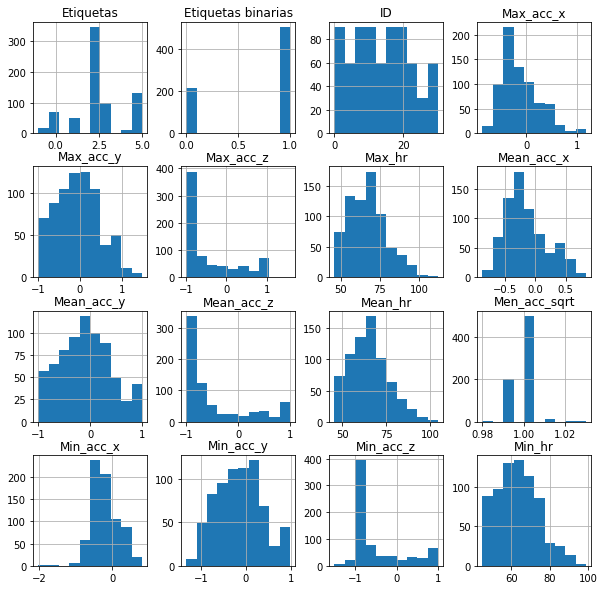

In [14]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TRAIN')
Train.hist(figsize=(10, 10))
plt.show()

In [15]:
Train.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,63.443056,67.375000,65.278722,0.997417,-0.187722,-0.116431,-0.151236,-0.152611,-0.043458,-0.097389,-0.502903,-0.414556,-0.464694,2.381944,0.700000,13.333333
std,10.607137,11.891416,10.981693,0.005113,0.364130,0.363518,0.341288,0.502682,0.520563,0.484869,0.625468,0.643131,0.618875,1.532207,0.458576,8.310725
min,45.000000,46.000000,45.500000,0.980000,-2.020000,-0.860000,-0.860000,-1.320000,-0.990000,-1.000000,-1.500000,-0.990000,-1.000000,-1.000000,0.000000,0.000000
25%,55.000000,59.000000,57.200000,0.990000,-0.430000,-0.370000,-0.400000,-0.540000,-0.440000,-0.460000,-0.920000,-0.880000,-0.900000,2.000000,0.000000,6.750000
50%,63.000000,67.000000,64.635000,1.000000,-0.270000,-0.200000,-0.240000,-0.150000,-0.065000,-0.120000,-0.820000,-0.770000,-0.790000,2.000000,1.000000,13.000000
75%,70.000000,74.000000,71.670000,1.000000,0.050000,0.090000,0.070000,0.200000,0.300000,0.240000,-0.240000,-0.050000,-0.190000,3.000000,1.000000,19.250000
max,99.000000,112.000000,104.500000,1.030000,0.820000,1.180000,0.830000,0.980000,1.480000,0.990000,0.990000,1.570000,1.000000,5.000000,1.000000,30.000000


HISTOGRAMA DATOS TEST


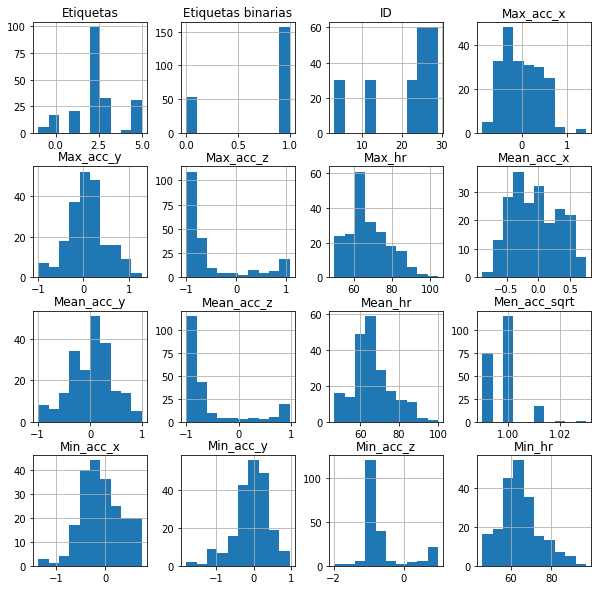

In [16]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TEST')
Test.hist(figsize=(10, 10))
plt.show()

In [17]:
Test.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas,Etiquetas binarias,ID
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.00000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,64.685714,67.971429,66.203429,0.997476,-0.092857,-0.000619,-0.044000,-0.044095,0.096476,0.025667,-0.62881,-0.505000,-0.570286,2.280952,0.742857,20.714286
std,9.431003,10.397329,9.757265,0.006621,0.413110,0.407283,0.371513,0.473320,0.425824,0.396762,0.61677,0.638074,0.595952,1.468039,0.438103,8.717484
min,46.000000,50.000000,46.670000,0.990000,-1.370000,-0.870000,-0.880000,-1.810000,-0.990000,-0.990000,-1.98000,-1.000000,-1.000000,-1.000000,0.000000,3.000000
25%,59.000000,62.000000,60.000000,0.990000,-0.407500,-0.307500,-0.350000,-0.280000,-0.190000,-0.220000,-0.95000,-0.920000,-0.927500,2.000000,0.000000,13.000000
50%,63.000000,66.000000,64.450000,1.000000,-0.125000,-0.030000,-0.080000,0.000000,0.095000,0.025000,-0.86500,-0.810000,-0.830000,2.000000,1.000000,25.000000
75%,69.000000,74.000000,71.645000,1.000000,0.247500,0.300000,0.267500,0.217500,0.337500,0.257500,-0.70500,-0.470000,-0.630000,3.000000,1.000000,27.000000
max,97.000000,104.000000,100.000000,1.030000,0.740000,1.420000,0.750000,0.970000,1.290000,0.990000,0.98000,1.070000,0.980000,5.000000,1.000000,29.000000


TAREAS:
- ¿Normalizar?
- Añadir feature: proxy de reloj
- 